In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler

In [3]:
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )


# create the combined fips county number of destination
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-destination'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# create the combined fips county number of source
df_migrations['statefips_str1'] = df_migrations['y1_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str1'] = df_migrations['y1_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-source'] = df_migrations['statefips_str1'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str1']


#Cleaning the data to have only source and origin counties and unemployment rate as a new column
df_migrations = df_migrations[df_migrations['y1_statefips']<=56]
df_migrations["Unemployment rate"] = df_migrations["n1"]/(df_migrations["n2"] +df_migrations["n1"] )
df_migrations1 = df_migrations[df_migrations['combined_fips-destination'] ==df_migrations['combined_fips-source']]  # keeping Unemployment rate of non migrants


 #drop useless information 
df_migrations = df_migrations.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])
df_migrations1 = df_migrations1.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])
df_migrations1 =df_migrations1.drop(columns=["agi","combined_fips-source"])



# remove nodes where data is undefined undefined data by zero
df_migrations = df_migrations[df_migrations['n1'] != -1]
df_migrations1 = df_migrations1[df_migrations1['n1'] != -1]

# convert combined fips to int64
df_migrations['combined_fips-destination'] = df_migrations['combined_fips-destination'].astype('int64')
df_migrations['combined_fips-source'] = df_migrations['combined_fips-source'].astype('int64')
df_migrations1['combined_fips-destination'] = df_migrations1['combined_fips-destination'].astype('int64')

df_migrations1= df_migrations1.drop(columns=["n1","n2","combined_fips-destination"])

#extracting the combined fips destination and combined fips source for graph in form of numpy arrays
df_graph= df_migrations.drop(columns=["n1","n2","agi","Unemployment rate"])

arr = df_graph.to_numpy()
print(df_migrations1)


       Unemployment rate
10              0.302760
31              0.316083
81              0.310380
98              0.300111
115             0.293537
...                  ...
86255           0.302733
86278           0.329863
86294           0.289025
86310           0.309895
86322           0.317928

[3141 rows x 1 columns]


In [4]:
possible_nodes = np.unique(arr)
print(possible_nodes)
A_migr = np.zeros((len(possible_nodes), len(possible_nodes))) 

for dest, source in arr : 
     
    i = np.where(possible_nodes == dest)
    #print(i)
    j = np.where(possible_nodes == source)
    #print(j)
    A_migr[j[0], i[0]] = 1
      
np.fill_diagonal(A_migr, 0)
z = df_migrations1.to_numpy()
d = dict(enumerate(z.flatten(), 0))



[ 1001  1003  1005 ... 56041 56043 56045]


In [5]:
G_migr = nx.from_numpy_matrix(A_migr,create_using = nx.DiGraph())

nx.set_node_attributes(G_migr,d,"Unemployment rate")
print('Number of nodes: {}, Number of edges: {}'. format(G_migr.number_of_nodes(), G_migr.number_of_edges()))
#print(' Number of connected components: {}'. format( nx.number_connected_components(G_migr)))
nx.write_gexf(G_migr, "test.gexf")
#print(signal[key])
#for i in range(3140):
#    print (G_migr.nodes[i])
#G_migr.nodes[2001]

Number of nodes: 3141, Number of edges: 46889


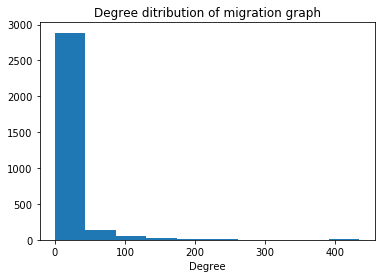

In [6]:
migr_citation = A_migr.sum(1)
migr_hist_normalization = np.ones(migr_citation.shape[0]) / migr_citation.shape[0]
plt.hist(migr_citation,bins = 10);
plt.gca().set(title='Degree ditribution of migration graph', xlabel='Degree');